In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [4]:
print(train_images.shape)


(60000, 28, 28)


In [5]:
print(train_labels.shape)


(60000,)


In [6]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [7]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5 #Normalizing Images between [-1,1]

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
BUFFER_SIZE = 60000 #this is same as no. of data to ensure that all the datas are shuffled
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 7, 7, 128)
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 14, 14, 64)
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model


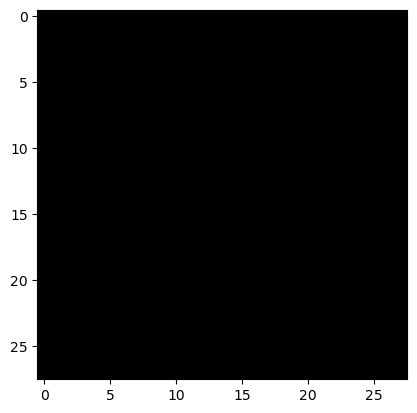

In [13]:
# Using the untrained generator to generate an image from random noise
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise,training=True)

plt.imshow(generated_image[0, :, :, 0],cmap='gray')


In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # First Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model



In [15]:
# Using the untrained discriminator to predict whether an image is real or fake
discriminator = make_discriminator_model()
decision = discriminator(tf.random.normal([1, 28, 28, 1]))
print(decision)


tf.Tensor([[-0.05273198]], shape=(1, 1), dtype=float32)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
#Discriminator Loss: Measures how well the discriminator can distinguish real images from fakes.
#Generator Loss: Measures how well the generator fools the discriminator.

def discriminator_loss(real_output, fake_output):
    # Compute cross-entropy loss for real images (should be classified as 1)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Compute cross-entropy loss for fake images (should be classified as 0)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Total loss is the sum of real and fake losses
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(fake_output):
    # Compute cross-entropy loss for fake images (should be classified as 1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Example usage:
# Assuming real_output and fake_output are the outputs from the discriminator for real and fake images
real_output = tf.random.normal([1, 1])  # Dummy data for real output
fake_output = tf.random.normal([1, 1])  # Dummy data for fake output

# Calculate losses
d_loss = discriminator_loss(real_output, fake_output)
g_loss = generator_loss(fake_output)

# Print the losses
print(f"Discriminator loss: {d_loss}")
print(f"Generator loss: {g_loss}")


Discriminator loss: 1.027023434638977
Generator loss: 0.7003774046897888


In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Epoch 1, Generator Loss: 0.701241135597229, Discriminator Loss: 1.6613893508911133


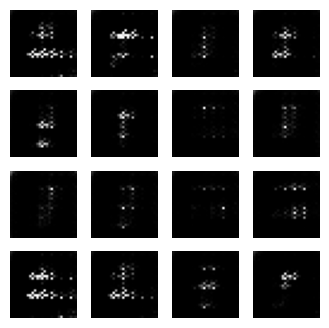

Epoch 2, Generator Loss: 0.8261536955833435, Discriminator Loss: 1.3212611675262451


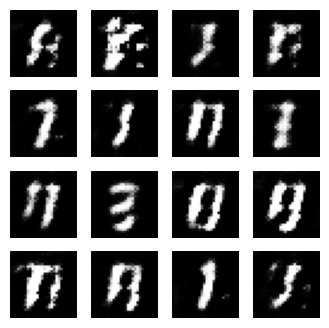

Epoch 3, Generator Loss: 0.806585967540741, Discriminator Loss: 1.271625280380249


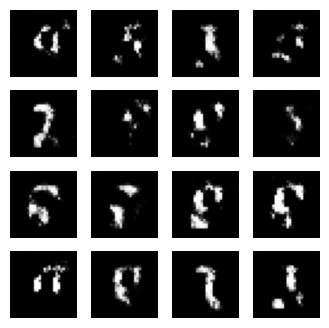

Epoch 4, Generator Loss: 0.811174750328064, Discriminator Loss: 1.3116521835327148


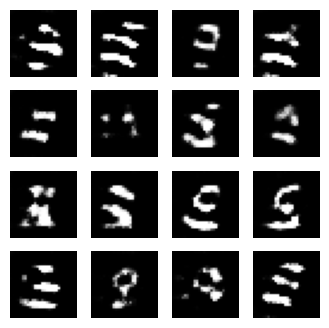

Epoch 5, Generator Loss: 0.9980387687683105, Discriminator Loss: 1.171954870223999


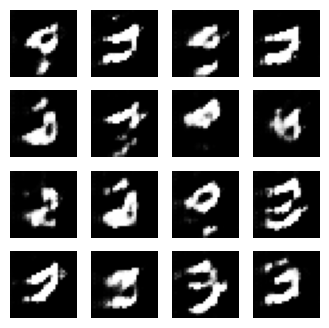

Epoch 6, Generator Loss: 1.3568446636199951, Discriminator Loss: 0.7791579961776733


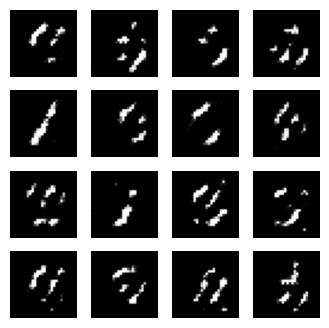

Epoch 7, Generator Loss: 1.2433626651763916, Discriminator Loss: 0.9289409518241882


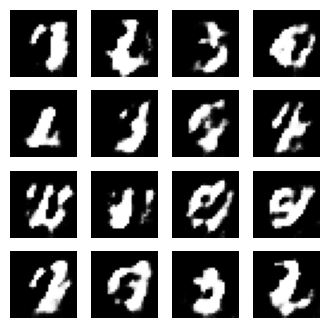

Epoch 8, Generator Loss: 0.9404171109199524, Discriminator Loss: 1.2597496509552002


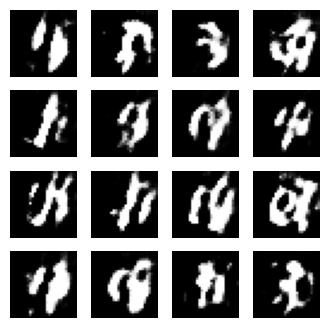

Epoch 9, Generator Loss: 1.0616810321807861, Discriminator Loss: 1.2422698736190796


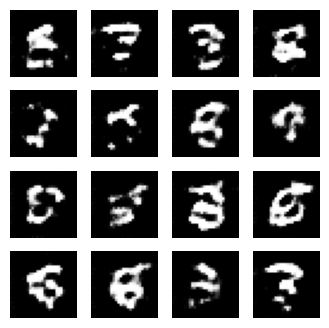

Epoch 10, Generator Loss: 1.0323045253753662, Discriminator Loss: 1.1829109191894531


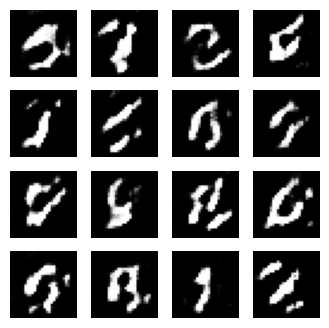

Epoch 11, Generator Loss: 1.3320974111557007, Discriminator Loss: 1.2847990989685059


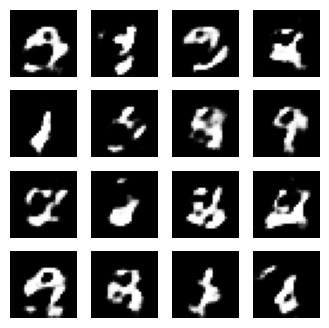

Epoch 12, Generator Loss: 1.0650923252105713, Discriminator Loss: 1.2021780014038086


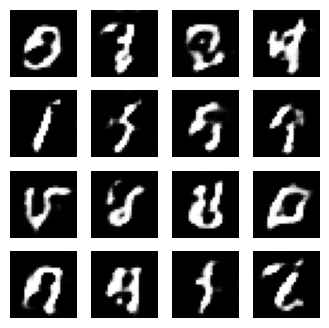

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Set up the generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

# Training parameters
EPOCHS = 100  # Increase the number of epochs
num_generator_updates = 2  # Update the generator more frequently
noise_dim = 100
BATCH_SIZE = 256
seed = tf.random.normal([16, noise_dim])

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            for _ in range(num_generator_updates):
                gen_loss, disc_loss = train_step(image_batch)
        
        # Print the loss values
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

        generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


train(train_dataset, EPOCHS)
